In [2]:
# randomly sample an image from 10_000 images
# extract the channels, convert each to black and white and display
# perform dwt on the image and extract only the LL feature and dislay it
# use a vae to encode it, and display each channel in black and white
# perform dwt on the encoded image and then extract onlt the LL features, display each on in blck and white

Using device: cuda
Loading VAE model...
Processing image: D:\DDP_amit_sethi\workspace-fast-dit\tiny-image-net-20-500\n01443537\images\n01443537_0.JPEG


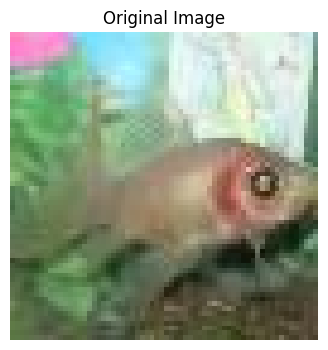


=== Step 1: Original Image Channels ===


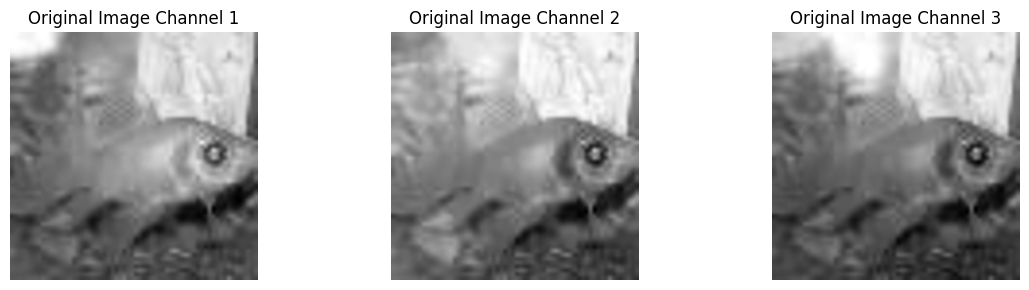


=== Step 2: DWT on Original Image (LL features) ===


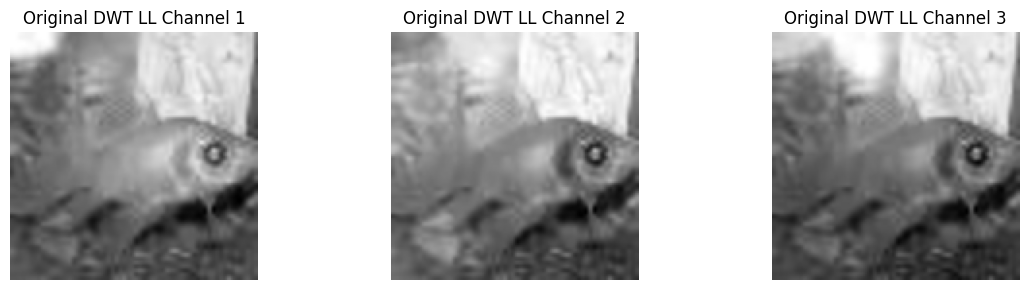


=== Step 3: VAE Encoding ===
VAE encoded shape: torch.Size([1, 4, 32, 32])


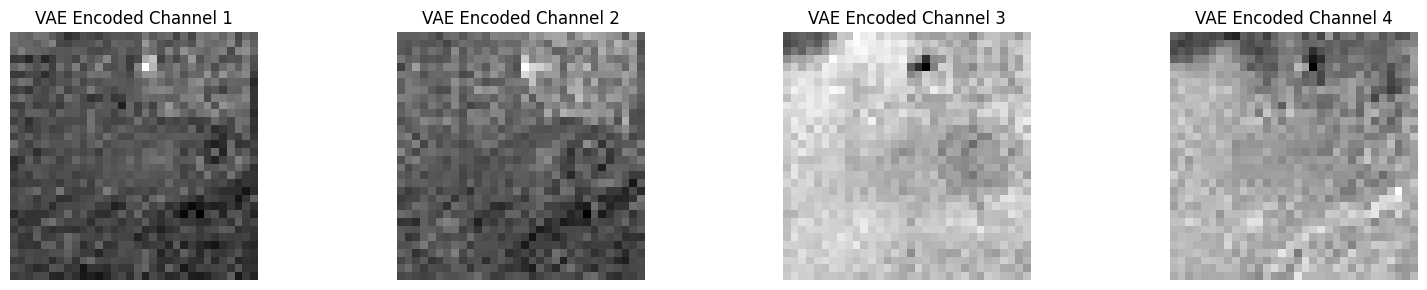


=== Step 4: DWT on VAE Encoded (LL features) ===


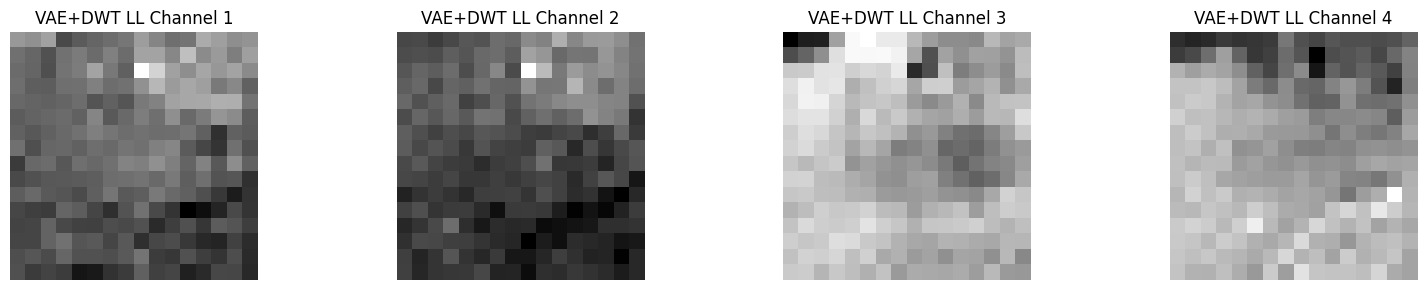

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from diffusers import AutoencoderKL
import random
import os
from pytorch_wavelets import DWTForward, DWTInverse
import glob

def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])

def extract_dwt_features(latent, num_dwt_levels=1, device='cpu'):
    """
    Extract features from the latent representation using Discrete Wavelet Transform (DWT).
    Returns both LL and high frequency components.
    """
    dwt = DWTForward(J=num_dwt_levels, wave='haar', mode='zero').to(device)
    ll, high_freq = dwt(latent)
    return ll, high_freq

def reconstruct_from_dwt(ll, high_freq, device='cpu'):
    """
    Reconstruct signal from DWT components using inverse DWT.
    """
    try:
        idwt = DWTInverse(wave='haar', mode='zero').to(device)
        # Debug: print structure
        print(f"LL shape: {ll.shape}")
        print(f"High freq structure: {type(high_freq)}, length: {len(high_freq)}")
        if len(high_freq) > 0:
            print(f"Level 0 type: {type(high_freq[0])}, length: {len(high_freq[0])}")
        
        # The DWTInverse expects coeffs in the format (ll, [high_freq_levels])
        reconstructed = idwt((ll, high_freq))
        return reconstructed
    except Exception as e:
        print(f"Error in DWT reconstruction: {e}")
        print("Falling back to LL features only...")
        return ll

def calculate_psnr(img1, img2):
    """
    Calculate Peak Signal-to-Noise Ratio (PSNR) between two images.
    Higher PSNR means better quality.
    """
    # Ensure tensors are on CPU and convert to numpy
    if isinstance(img1, torch.Tensor):
        img1 = img1.cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.cpu().numpy()
    
    # Calculate MSE
    mse = np.mean((img1 - img2) ** 2)
    
    # Avoid division by zero
    if mse == 0:
        return float('inf')
    
    # Calculate PSNR (assuming pixel values are in range [-1, 1] for normalized tensors)
    max_pixel_value = 2.0  # Range is [-1, 1], so max difference is 2
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    
    return psnr

def load_random_images(image_folder, num_images=10000, sample_size=1):
    """
    Load random images from a folder containing up to num_images
    """
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    all_images = []
    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(image_folder, '**', ext), recursive=True))
    
    # Limit to num_images and randomly sample
    available_images = all_images[:num_images] if len(all_images) > num_images else all_images
    sampled_images = random.sample(available_images, min(sample_size, len(available_images)))
    
    return sampled_images

def display_channels(image_tensor, title_prefix=""):
    """
    Display each channel of an image tensor in black and white
    """
    if len(image_tensor.shape) == 4:  # (batch, channels, height, width)
        image_tensor = image_tensor[0]  # Take first batch item
    
    channels = image_tensor.shape[0]
    fig, axes = plt.subplots(1, channels, figsize=(4*channels, 3))
    
    if channels == 1:
        axes = [axes]
    
    for i in range(channels):
        channel_data = image_tensor[i].cpu().numpy()
        axes[i].imshow(channel_data, cmap='gray')
        axes[i].set_title(f'{title_prefix} Channel {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def tensor_to_pil(tensor):
    """
    Convert a tensor to PIL Image for display
    """
    # Denormalize from [-1, 1] to [0, 1]
    tensor = (tensor + 1.0) / 2.0
    tensor = torch.clamp(tensor, 0, 1)
    
    # Convert to numpy and rearrange dimensions
    if len(tensor.shape) == 4:  # (batch, channels, height, width)
        tensor = tensor[0]  # Take first batch item
    
    # Convert from (C, H, W) to (H, W, C)
    np_image = tensor.cpu().numpy().transpose(1, 2, 0)
    
    # Convert to uint8 and create PIL image
    np_image = (np_image * 255).astype(np.uint8)
    return Image.fromarray(np_image)

def process_and_visualize_image(image_path, image_size=512, vae_model="mse"):
    """
    Complete pipeline: load image -> VAE encode -> DWT -> reconstruct with/without high freq -> VAE decode
    """
    # Setup device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load VAE model
    print("Loading VAE model...")
    vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{vae_model}").to(device)
    
    # Load and preprocess image
    print(f"Processing image: {image_path}")
    pil_image = Image.open(image_path).convert('RGB')
    
    # Show original image
    plt.figure(figsize=(4, 4))
    plt.imshow(pil_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Apply transformations
    transform = transforms.Compose([
        transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3, inplace=True)
    ])
    
    image_tensor = transform(pil_image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Step 1: Display original image channels
    print("\n=== Step 1: Original Image Channels ===")
    display_channels(image_tensor, "Original Image")
    
    # Step 2: VAE encode the original image
    print("\n=== Step 2: VAE Encoding ===")
    with torch.no_grad():
        encoded = vae.encode(image_tensor).latent_dist.sample().mul_(0.18215)
    
    print(f"VAE encoded shape: {encoded.shape}")
    display_channels(encoded, "VAE Encoded")
    
    # Step 3: Apply DWT to VAE encoded image and extract all components
    print("\n=== Step 3: Extract DWT Components ===")
    dwt_ll, dwt_high_freq = extract_dwt_features(encoded, num_dwt_levels=1, device=device)
    print(f"DWT LL features shape: {dwt_ll.shape}")
    print(f"DWT high freq components: {len(dwt_high_freq)} levels")
    if len(dwt_high_freq) > 0:
        print(f"High freq level 0 type: {type(dwt_high_freq[0])}")
        print(f"High freq level 0 length: {len(dwt_high_freq[0])}")
        for i, coeff in enumerate(dwt_high_freq[0]):
            print(f"  Coeff {i} shape: {coeff.shape}")
    display_channels(dwt_ll, "DWT LL Features")
    
    # Step 4a: Use LL features directly as latent (simplified approach)
    print("\n=== Step 4a: Direct LL Features as Latent ===")
    # Since LL features are 1/4 the size due to DWT, we need to interpolate back
    # or use them directly if the VAE can handle different sizes
    
    # Try to decode LL features directly
    try:
        with torch.no_grad():
            decoded_ll_direct = vae.decode(dwt_ll.div_(0.18215)).sample
        print(f"Successfully decoded LL features directly. Shape: {decoded_ll_direct.shape}")
        ll_direct_success = True
    except Exception as e:
        print(f"Cannot decode LL features directly: {e}")
        # Upsample LL to original encoded size
        ll_upsampled = torch.nn.functional.interpolate(dwt_ll, size=encoded.shape[-2:], mode='bilinear', align_corners=False)
        with torch.no_grad():
            decoded_ll_direct = vae.decode(ll_upsampled.div_(0.18215)).sample
        print(f"Used upsampled LL features. Shape: {decoded_ll_direct.shape}")
        ll_direct_success = False
    
    # Step 4b: Attempt full DWT reconstruction
    print("\n=== Step 4b: Full DWT Reconstruction ===")
    try:
        # Try DWT reconstruction
        reconstructed_full = reconstruct_from_dwt(dwt_ll, dwt_high_freq, device=device)
        print(f"DWT reconstruction successful. Shape: {reconstructed_full.shape}")
        
        # VAE decode from full reconstruction
        with torch.no_grad():
            decoded_full = vae.decode(reconstructed_full.div_(0.18215)).sample
        
        dwt_recon_success = True
    except Exception as e:
        print(f"DWT reconstruction failed: {e}")
        print("Using original encoded as 'full reconstruction'")
        reconstructed_full = encoded
        with torch.no_grad():
            decoded_full = vae.decode(encoded.div_(0.18215)).sample
        dwt_recon_success = False
    
    # Step 5: Calculate PSNR values
    print("\n=== Step 5: PSNR Analysis ===")
    
    # PSNR between original and LL-only reconstruction
    psnr_ll_only = calculate_psnr(image_tensor, decoded_ll_direct)
    print(f"PSNR (Original vs LL-only reconstruction): {psnr_ll_only:.2f} dB")
    
    # PSNR between original and full reconstruction
    psnr_full = calculate_psnr(image_tensor, decoded_full)
    print(f"PSNR (Original vs Full reconstruction): {psnr_full:.2f} dB")
    
    # PSNR improvement by adding high frequency components
    psnr_improvement = psnr_full - psnr_ll_only
    print(f"PSNR improvement by adding high freq components: {psnr_improvement:.2f} dB")
    
    # Additional comparison: VAE-only (without DWT processing)
    with torch.no_grad():
        vae_only_decoded = vae.decode(encoded.div_(0.18215)).sample
    psnr_vae_only = calculate_psnr(image_tensor, vae_only_decoded)
    print(f"PSNR (VAE encoding/decoding without DWT): {psnr_vae_only:.2f} dB")
    
    # Step 6: Visual comparison
    print("\n=== Step 6: Visual Comparison ===")
    
    # Convert tensors to PIL images
    original_pil = tensor_to_pil(image_tensor)
    ll_only_pil = tensor_to_pil(decoded_ll_direct)
    full_recon_pil = tensor_to_pil(decoded_full)
    vae_only_pil = tensor_to_pil(vae_only_decoded)
    
    # Display comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    axes[0,0].imshow(original_pil)
    axes[0,0].set_title("Original Image")
    axes[0,0].axis('off')
    
    axes[0,1].imshow(vae_only_pil)
    axes[0,1].set_title(f"VAE Only\nPSNR: {psnr_vae_only:.2f} dB")
    axes[0,1].axis('off')
    
    axes[1,0].imshow(ll_only_pil)
    ll_method = "Direct LL" if ll_direct_success else "Upsampled LL"
    axes[1,0].set_title(f"{ll_method} Reconstruction\nPSNR: {psnr_ll_only:.2f} dB")
    axes[1,0].axis('off')
    
    axes[1,1].imshow(full_recon_pil)
    full_method = "Full DWT" if dwt_recon_success else "VAE Only (fallback)"
    axes[1,1].set_title(f"{full_method} Reconstruction\nPSNR: {psnr_full:.2f} dB")
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Show the difference images
    print("\n=== Step 7: Difference Analysis ===")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Difference between original and LL-only
    diff_ll = torch.abs(image_tensor - decoded_ll_direct)
    diff_ll_img = tensor_to_pil(diff_ll)
    axes[0].imshow(diff_ll_img)
    axes[0].set_title("Difference: Original - LL-only")
    axes[0].axis('off')
    
    # Difference between original and full reconstruction
    diff_full = torch.abs(image_tensor - decoded_full)
    diff_full_img = tensor_to_pil(diff_full)
    axes[1].imshow(diff_full_img)
    axes[1].set_title("Difference: Original - Full")
    axes[1].axis('off')
    
    # High frequency contribution
    high_freq_contribution = torch.abs(decoded_full - decoded_ll_direct)
    high_freq_img = tensor_to_pil(high_freq_contribution)
    axes[2].imshow(high_freq_img)
    axes[2].set_title("High Freq Contribution\n(Full - LL-only)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'original': image_tensor,
        'vae_encoded': encoded,
        'dwt_ll': dwt_ll,
        'dwt_high_freq': dwt_high_freq,
        'decoded_ll_only': decoded_ll_direct,
        'decoded_full': decoded_full,
        'vae_only_decoded': vae_only_decoded,
        'psnr_ll_only': psnr_ll_only,
        'psnr_full': psnr_full,
        'psnr_vae_only': psnr_vae_only,
        'psnr_improvement': psnr_improvement,
        'll_direct_success': ll_direct_success,
        'dwt_recon_success': dwt_recon_success
    }

# Example usage
if __name__ == "__main__":
    image_path = r"D:\DDP_amit_sethi\workspace-fast-dit\tiny-image-net-20-500\n01443537\images\n01443537_0.JPEG"  # Update this path
    results = process_and_visualize_image(image_path, image_size=256, vae_model="mse")

d:\DDP_amit_sethi\workspace-fast-dit\fast\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading VAE model...
Processing image: D:\DDP_amit_sethi\workspace-fast-dit\tiny-image-net-20-500\n01443537\images\n01443537_0.JPEG


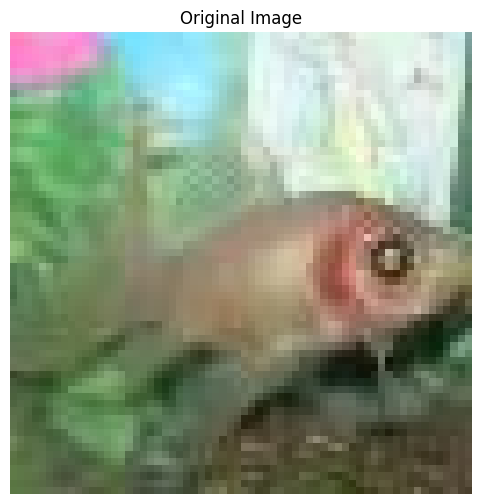

VAE Encoding...
Encoded latent shape: torch.Size([1, 4, 32, 32])

Energy Analysis:
LL: 3.44e+03
LH: 2.92e+02
HL: 2.96e+02
HH: 2.17e+02

Testing different feature combinations...

Processing: LL only
PSNR: 24.44 dB, MSE: 0.003614

Processing: LL + LH
PSNR: 26.79 dB, MSE: 0.002101

Processing: LL + HL
PSNR: 27.23 dB, MSE: 0.001895

Processing: LL + HH
PSNR: 25.20 dB, MSE: 0.003030

Processing: LL + LH + HL
PSNR: 31.99 dB, MSE: 0.000633

Processing: LL + LH + HL + HH
PSNR: 40.11 dB, MSE: 0.000098

Displaying reconstruction comparison...


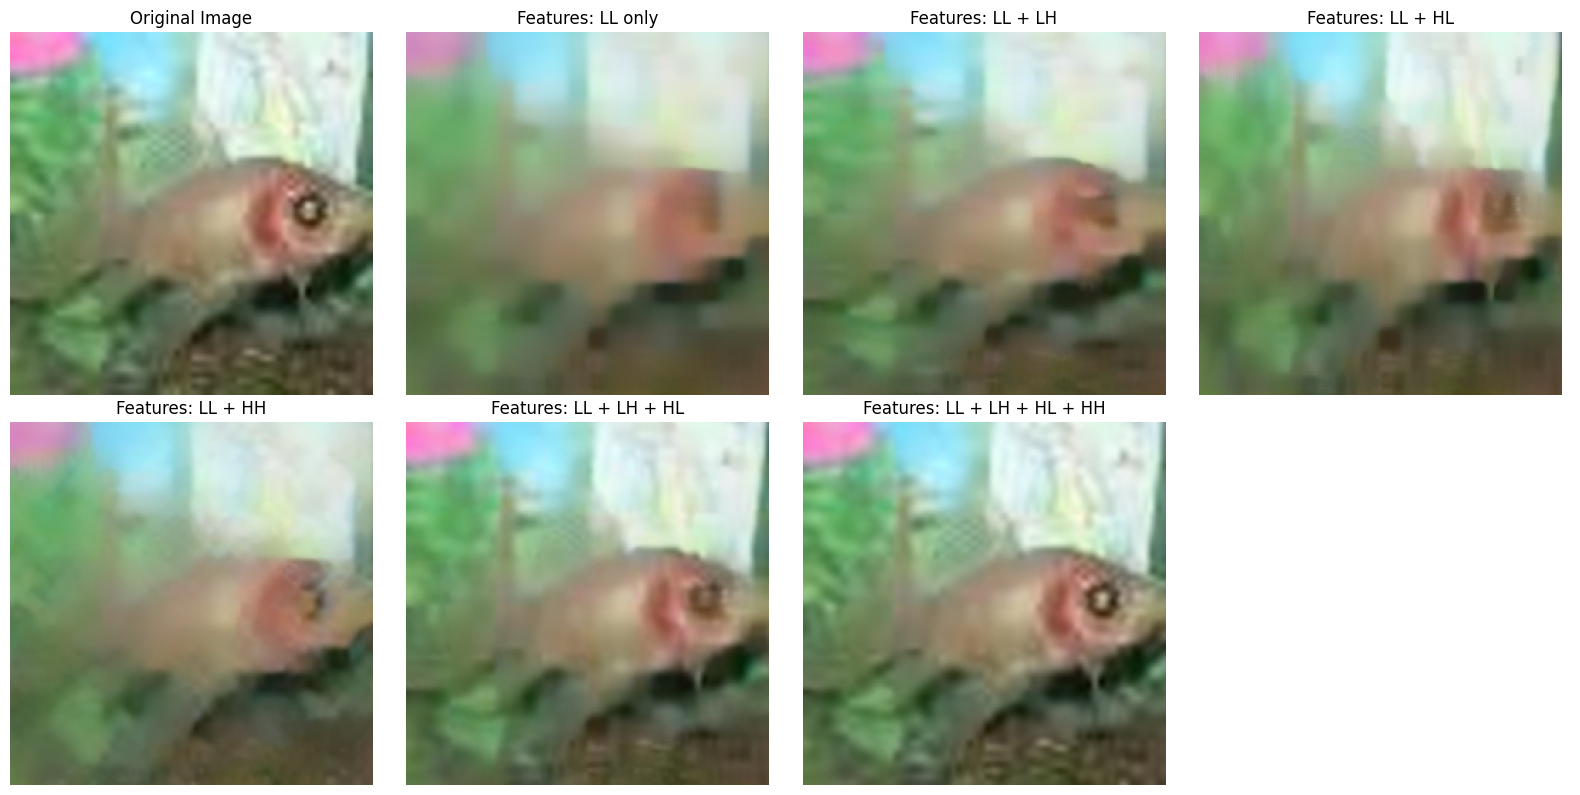


Generating analysis plots...


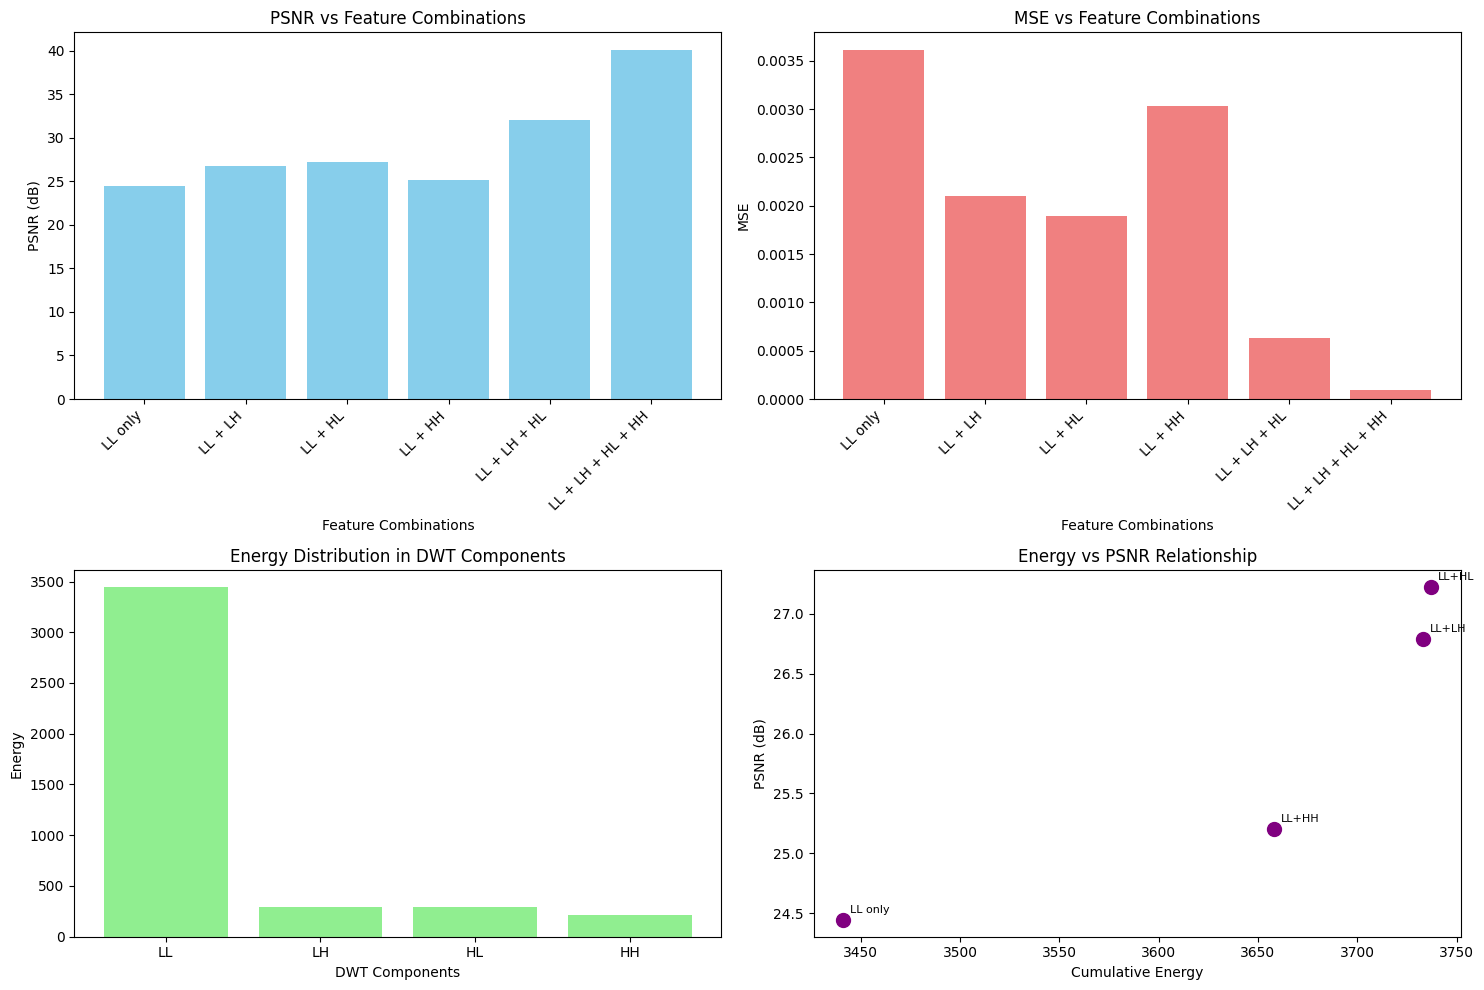


SUMMARY ANALYSIS

Feature Combination Results:
LL only              | PSNR:  24.44 dB | MSE: 0.003614
LL + LH              | PSNR:  26.79 dB | MSE: 0.002101
LL + HL              | PSNR:  27.23 dB | MSE: 0.001895
LL + HH              | PSNR:  25.20 dB | MSE: 0.003030
LL + LH + HL         | PSNR:  31.99 dB | MSE: 0.000633
LL + LH + HL + HH    | PSNR:  40.11 dB | MSE: 0.000098

Best PSNR: 40.11 dB (LL + LH + HL + HH)
Lowest MSE: 0.000098 (LL + LH + HL + HH)

Energy Distribution (% of total):
LL: 81.03%
LH: 6.88%
HL: 6.97%
HH: 5.11%


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from diffusers import AutoencoderKL
import random
import os
import pywt
import glob
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])

def extract_dwt_features(latent, device='cpu'):
    """
    Extract features using PyWavelets DWT.
    Returns LL coefficients and high frequency components (LH, HL, HH).
    """
    # Convert to numpy for pywt processing
    latent_np = latent.cpu().numpy()
    
    dwt_coeffs = []
    ll_coeffs = []
    
    # Process each sample and channel separately
    for b in range(latent_np.shape[0]):
        batch_coeffs = []
        batch_ll = []
        for c in range(latent_np.shape[1]):
            coeffs = pywt.dwt2(latent_np[b, c], 'haar')
            ll, (lh, hl, hh) = coeffs
            batch_coeffs.append((lh, hl, hh))
            batch_ll.append(ll)
        dwt_coeffs.append(batch_coeffs)
        ll_coeffs.append(batch_ll)
    
    return ll_coeffs, dwt_coeffs

def reconstruct_from_dwt_features(ll_coeffs, dwt_coeffs, feature_mask, device='cpu'):
    """
    Reconstruct using PyWavelets IDWT with selective features.
    feature_mask: dict with keys 'LH', 'HL', 'HH' indicating which features to use
    """
    reconstructed_batch = []
    
    for b in range(len(ll_coeffs)):
        reconstructed_channels = []
        for c in range(len(ll_coeffs[b])):
            ll = ll_coeffs[b][c]
            lh, hl, hh = dwt_coeffs[b][c]
            
            # Zero out features not in mask
            if not feature_mask.get('LH', False):
                lh = np.zeros_like(lh)
            if not feature_mask.get('HL', False):
                hl = np.zeros_like(hl)
            if not feature_mask.get('HH', False):
                hh = np.zeros_like(hh)
            
            # Reconstruct using IDWT
            reconstructed_channel = pywt.idwt2((ll, (lh, hl, hh)), 'haar')
            reconstructed_channels.append(reconstructed_channel)
        
        reconstructed_batch.append(np.stack(reconstructed_channels, axis=0))
    
    # Convert back to torch tensor
    reconstructed = torch.from_numpy(np.stack(reconstructed_batch, axis=0)).float().to(device)
    return reconstructed

def calculate_energy(coeffs_list):
    """Calculate energy (sum of squared coefficients) of wavelet coefficients"""
    total_energy = 0
    for batch in coeffs_list:
        if isinstance(batch, list):
            for coeff in batch:
                if isinstance(coeff, tuple):
                    # For high freq coefficients (LH, HL, HH)
                    for component in coeff:
                        total_energy += np.sum(component ** 2)
                else:
                    # For LL coefficients
                    total_energy += np.sum(coeff ** 2)
        else:
            total_energy += np.sum(batch ** 2)
    return total_energy

def calculate_individual_component_energy(dwt_coeffs, component_idx):
    """Calculate energy for a specific component (0=LH, 1=HL, 2=HH)"""
    total_energy = 0
    for batch in dwt_coeffs:
        for channel_coeffs in batch:
            total_energy += np.sum(channel_coeffs[component_idx] ** 2)
    return total_energy

def calculate_metrics(original, reconstructed):
    """Calculate PSNR and MSE between original and reconstructed images"""
    # Convert to numpy and ensure proper range [0, 1]
    orig_np = ((original.cpu().numpy() + 1) / 2).clip(0, 1)
    recon_np = ((reconstructed.cpu().numpy() + 1) / 2).clip(0, 1)
    
    # Calculate metrics for each channel and average
    psnr_values = []
    mse_values = []
    
    for c in range(orig_np.shape[1]):  # For each channel
        psnr = peak_signal_noise_ratio(orig_np[0, c], recon_np[0, c], data_range=1.0)
        mse = mean_squared_error(orig_np[0, c], recon_np[0, c])
        psnr_values.append(psnr)
        mse_values.append(mse)
    
    return np.mean(psnr_values), np.mean(mse_values)

def display_channels(image_tensor, title_prefix=""):
    """
    Display each channel of an image tensor in black and white
    """
    if len(image_tensor.shape) == 4:  # (batch, channels, height, width)
        image_tensor = image_tensor[0]  # Take first batch item
    
    channels = image_tensor.shape[0]
    fig, axes = plt.subplots(1, channels, figsize=(4*channels, 3))
    
    if channels == 1:
        axes = [axes]
    
    for i in range(channels):
        channel_data = image_tensor[i].cpu().numpy()
        axes[i].imshow(channel_data, cmap='gray')
        axes[i].set_title(f'{title_prefix} Channel {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def display_reconstruction_comparison(original, reconstructions, feature_combinations):
    """Display original and all reconstructions for comparison"""
    n_recons = len(reconstructions)
    n_cols = min(4, n_recons + 1)  # Max 4 columns
    n_rows = (n_recons + 1 + n_cols - 1) // n_cols  # Calculate needed rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    axes = axes.flatten()
    
    # Display original
    orig_display = ((original[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
    axes[0].imshow(orig_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Display reconstructions
    for i, (recon, combo) in enumerate(zip(reconstructions, feature_combinations)):
        recon_display = ((recon[0].cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
        axes[i + 1].imshow(recon_display)
        axes[i + 1].set_title(f"Features: {combo}")
        axes[i + 1].axis('off')
    
    # Hide unused subplots
    for i in range(len(reconstructions) + 1, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(feature_combinations, psnr_values, mse_values, energy_analysis):
    """Plot PSNR, MSE, and energy analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # PSNR comparison
    ax1.bar(range(len(feature_combinations)), psnr_values, color='skyblue')
    ax1.set_xlabel('Feature Combinations')
    ax1.set_ylabel('PSNR (dB)')
    ax1.set_title('PSNR vs Feature Combinations')
    ax1.set_xticks(range(len(feature_combinations)))
    ax1.set_xticklabels(feature_combinations, rotation=45, ha='right')
    
    # MSE comparison
    ax2.bar(range(len(feature_combinations)), mse_values, color='lightcoral')
    ax2.set_xlabel('Feature Combinations')
    ax2.set_ylabel('MSE')
    ax2.set_title('MSE vs Feature Combinations')
    ax2.set_xticks(range(len(feature_combinations)))
    ax2.set_xticklabels(feature_combinations, rotation=45, ha='right')
    
    # Energy analysis
    energy_types = list(energy_analysis.keys())
    energy_vals = list(energy_analysis.values())
    ax3.bar(energy_types, energy_vals, color='lightgreen')
    ax3.set_xlabel('DWT Components')
    ax3.set_ylabel('Energy')
    ax3.set_title('Energy Distribution in DWT Components')
    
    # Energy vs PSNR correlation
    # Create a mapping of individual features to their contribution
    individual_features = ['LL only', 'LL+LH', 'LL+HL', 'LL+HH']
    if len(feature_combinations) >= 4:
        individual_psnr = psnr_values[:4]
        feature_energies = [energy_analysis['LL'], 
                          energy_analysis['LL'] + energy_analysis['LH'],
                          energy_analysis['LL'] + energy_analysis['HL'],
                          energy_analysis['LL'] + energy_analysis['HH']]
        
        ax4.scatter(feature_energies, individual_psnr, color='purple', s=100)
        ax4.set_xlabel('Cumulative Energy')
        ax4.set_ylabel('PSNR (dB)')
        ax4.set_title('Energy vs PSNR Relationship')
        
        # Add labels for each point
        for i, label in enumerate(individual_features):
            ax4.annotate(label, (feature_energies[i], individual_psnr[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def process_and_analyze_dwt_features(image_path, image_size=512, vae_model="mse"):
    """
    Complete analysis pipeline for DWT feature contribution using PyWavelets
    """
    # Setup device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load VAE model
    print("Loading VAE model...")
    vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{vae_model}").to(device)
    
    # Load and preprocess image
    print(f"Processing image: {image_path}")
    pil_image = Image.open(image_path).convert('RGB')
    
    # Show original image
    plt.figure(figsize=(6, 6))
    plt.imshow(pil_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Apply transformations
    transform = transforms.Compose([
        transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3, inplace=True)
    ])
    
    image_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    # VAE encode the original image
    print("VAE Encoding...")
    with torch.no_grad():
        encoded = vae.encode(image_tensor).latent_dist.sample().mul_(0.18215)
    
    print(f"Encoded latent shape: {encoded.shape}")
    
    # Extract DWT features from encoded latent
    ll_coeffs, dwt_coeffs = extract_dwt_features(encoded, device=device)
    
    # Calculate energy for each component
    ll_energy = calculate_energy(ll_coeffs)
    lh_energy = calculate_individual_component_energy(dwt_coeffs, 0)  # LH
    hl_energy = calculate_individual_component_energy(dwt_coeffs, 1)  # HL
    hh_energy = calculate_individual_component_energy(dwt_coeffs, 2)  # HH
    
    energy_analysis = {
        'LL': ll_energy,
        'LH': lh_energy,
        'HL': hl_energy,
        'HH': hh_energy
    }
    
    print("\nEnergy Analysis:")
    for component, energy in energy_analysis.items():
        print(f"{component}: {energy:.2e}")
    
    # Define feature combinations to test
    feature_combinations = [
        "LL only",
        "LL + LH", 
        "LL + HL",
        "LL + HH",
        "LL + LH + HL",
        "LL + LH + HL + HH"
    ]
    
    feature_masks = [
        {'LH': False, 'HL': False, 'HH': False},  # LL only
        {'LH': True, 'HL': False, 'HH': False},   # LL + LH
        {'LH': False, 'HL': True, 'HH': False},   # LL + HL
        {'LH': False, 'HL': False, 'HH': True},   # LL + HH
        {'LH': True, 'HL': True, 'HH': False},    # LL + LH + HL
        {'LH': True, 'HL': True, 'HH': True},     # LL + LH + HL + HH
    ]
    
    reconstructions = []
    psnr_values = []
    mse_values = []
    
    print("\nTesting different feature combinations...")
    
    for i, (combo, mask) in enumerate(zip(feature_combinations, feature_masks)):
        print(f"\nProcessing: {combo}")
        
        # Reconstruct latent using IDWT with selected features
        reconstructed_latent = reconstruct_from_dwt_features(ll_coeffs, dwt_coeffs, mask, device)
        
        # VAE decode to get final image
        with torch.no_grad():
            reconstructed_image = vae.decode(reconstructed_latent / 0.18215).sample
        
        # Calculate metrics
        psnr, mse = calculate_metrics(image_tensor, reconstructed_image)
        
        reconstructions.append(reconstructed_image)
        psnr_values.append(psnr)
        mse_values.append(mse)
        
        print(f"PSNR: {psnr:.2f} dB, MSE: {mse:.6f}")
    
    # Display comparison
    print("\nDisplaying reconstruction comparison...")
    display_reconstruction_comparison(image_tensor, reconstructions, feature_combinations)
    
    # Plot metrics and analysis
    print("\nGenerating analysis plots...")
    plot_metrics_comparison(feature_combinations, psnr_values, mse_values, energy_analysis)
    
    # Summary analysis
    print("\n" + "="*50)
    print("SUMMARY ANALYSIS")
    print("="*50)
    
    print("\nFeature Combination Results:")
    for combo, psnr, mse in zip(feature_combinations, psnr_values, mse_values):
        print(f"{combo:20s} | PSNR: {psnr:6.2f} dB | MSE: {mse:.6f}")
    
    print(f"\nBest PSNR: {max(psnr_values):.2f} dB ({feature_combinations[psnr_values.index(max(psnr_values))]})")
    print(f"Lowest MSE: {min(mse_values):.6f} ({feature_combinations[mse_values.index(min(mse_values))]})")
    
    print("\nEnergy Distribution (% of total):")
    total_energy = sum(energy_analysis.values())
    for component, energy in energy_analysis.items():
        percentage = (energy / total_energy) * 100
        print(f"{component}: {percentage:.2f}%")

    
    return {
        'feature_combinations': feature_combinations,
        'psnr_values': psnr_values,
        'mse_values': mse_values,
        'energy_analysis': energy_analysis,
        'reconstructions': reconstructions
    }

# Example usage
if __name__ == "__main__":
    # Update this path to your image
    image_path = r"D:\DDP_amit_sethi\workspace-fast-dit\tiny-image-net-20-500\n01443537\images\n01443537_0.JPEG"
    
    # Run the complete analysis
    results = process_and_analyze_dwt_features(image_path, image_size=256, vae_model="mse")